In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook
from imblearn.over_sampling import SMOTE
from collections import Counter

In [3]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [4]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [16]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Aceleration'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Aceleracao
0,1409.565056,1291.374765,1127.937101,1663.806440,2056.763003,NaN,77.103974,95.577887,0.454945,0.500616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1507.926208,1309.115732,1242.659913,1530.587966,2098.250774,NaN,71.061984,91.039134,0.409187,NaN,...,NaN,NaN,NaN,NaN,NaN,53.401821,47.982676,5.691769,10.846115,1
2,1513.425447,1301.218322,1241.176354,1669.921950,2135.010554,NaN,72.050229,93.021177,0.415841,NaN,...,NaN,NaN,NaN,NaN,NaN,51.888566,51.800628,6.321324,4.606555,1
3,1369.669287,1262.398125,1180.965717,1368.187563,1987.070532,550.848527,102.342058,152.610215,0.434121,0.588756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1384.641327,1362.557218,1171.793778,1654.978161,1976.940021,NaN,84.700554,102.049056,0.457152,NaN,...,NaN,NaN,NaN,NaN,NaN,46.084792,42.528714,12.293491,4.819045,1


In [17]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1409.565056          1291.374765         1127.937101  1663.806440   
1       1507.926208          1309.115732         1242.659913  1530.587966   
2       1513.425447          1301.218322         1241.176354  1669.921950   
3       1369.669287          1262.398125         1180.965717  1368.187563   
4       1384.641327          1362.557218         1171.793778  1654.978161   
...             ...                  ...                 ...          ...   
996     1366.260071          1344.071570         1265.280794  1564.856065   
997     1505.649795          1318.139122         1233.642827  1540.427717   
998     1404.823434          1328.158609         1248.488797  1473.317271   
999             NaN                  NaN                 NaN          NaN   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [18]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Entre-Eixo',
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
    'DP_Altura',
    'DP_Comprimento',
    'DP_Altura do CG com relacao ao chao',
    'DMV_Lado Direito',
    'ST_Curso Positivo de projeto',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'ST_Curso Negativo de projeto',
    'D_Relacao',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'CD_Raio mínimo de curva do protótipo',
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [19]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 27 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   MV_Eixo dianteiro                                        736 non-null    float64
 1   MV_Eixo Traseiro                                         736 non-null    float64
 2   DMV_Dianteira                                            736 non-null    float64
 3   PCG_X                                                    736 non-null    float64
 4   PCG_Y                                                    961 non-null    float64
 5   PCG_Z                                                    736 non-null    float64
 6   SD_Dimensoes dos pneus                                   1001 non-null   float64
 7   SD_Cambagem estatica                                     217 non-null    float64
 8   SD_Convergência estatica    

In [20]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.") 

'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 46.
'PCG_Z' tem 0.
'SD_Dimensoes dos pneus' tem 743.
'SD_Cambagem estatica' tem 134.
'SD_Convergência estatica' tem 147.
'ST_Dimensoes dos pneus' tem 743.
'ST_Cambagem estatica' tem 132.
'ST_Convergência estatica' tem 149.
'MT_Potência maxima do motor' tem 0.
'MT_Torque maximo do motor' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'CD_Velocidade crítica para uma curva de raio de 10 m' tem 0.
'CD_Distancia de frenagem de 35 a 0 em asfalto' tem 0.
'CD_Distancia de frenagem de 35 a 0 em terra batida' tem 0.
'CD_Ganho de rolagem por aceleracao lateral' tem 0.
'CD_Ganho de arfagem em aceleracao longitudinal' tem 1.
'CD_Ganho de arfagem em desaceleracao longitudinal' tem 1.
'CD_Velocidade maxima de 0 a 100 metros em asfalto ' tem 0.
'CD_Velocidade maxima de 0 a 100 metros em terra batida ' tem 0.
'CD_Tempo para atingir velocidade maxima em asfalto' tem 0.
'CD_Tempo par

## Limpeza

In [21]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

MV_Eixo dianteiro                                          265
MV_Eixo Traseiro                                           265
DMV_Dianteira                                              265
PCG_X                                                      265
PCG_Y                                                       40
PCG_Z                                                      265
SD_Dimensoes dos pneus                                       0
ST_Dimensoes dos pneus                                       0
MT_Relacao total_max                                       238
MT_Relacao total_min                                       250
CD_Velocidade maxima de 0 a 100 metros em asfalto          633
CD_Velocidade maxima de 0 a 100 metros em terra batida     651
CD_Tempo para atingir velocidade maxima em asfalto         669
CD_Tempo para atingir velocidade maxima em terra batida    684
P_Aceleracao                                                 0
dtype: int64

In [22]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([206, 209, 211, 212, 213, 217, 221, 225, 228, 229,
            ...
            980, 983, 984, 985, 987, 989, 990, 993, 994, 999],
           dtype='int64', length=265)
      MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0             77.103974         95.577887       0.454945  208.702782   
1             71.061984         91.039134       0.409187  514.604278   
2             72.050229         93.021177       0.415841  491.093155   
3            102.342058        152.610215       0.434121   85.197422   
4             84.700554        102.049056       0.457152  368.632469   
...                 ...               ...            ...         ...   
995           72.221809         90.226812       0.441886  107.916108   
996           70.709528         98.908065       0.401583   69.576836   
997           60.558489        107.230112       0.352453  523.000000   
998           69.774043         96.836258       0.410884  109.438324   
1000         114.320000      

In [23]:
# Pela análise dos dados se percebe que as colunas de Dimensões de Pneus trazem muitos valores zerados
df = df.drop(['SD_Dimensoes dos pneus'], axis=1)
df = df.drop(['ST_Dimensoes dos pneus'], axis=1)

In [24]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Aceleracao'] = df['P_Aceleracao'].replace(mapeamento)

print(df['P_Aceleracao'])

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
995     4.0
996     4.0
997     4.0
998     4.0
1000    4.0
Name: P_Aceleracao, Length: 736, dtype: float64


In [25]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=0)

In [26]:
#Descrição de dados
df.describe()

,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,PCG_X,PCG_Y,PCG_Z,MT_Relacao total_max,MT_Relacao total_min,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Aceleracao
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,723.000000,711.000000,368.000000,350.000000,332.000000,317.000000,736.000000
mean,75.742159,105.275504,0.417622,298.232713,155.091859,-358.056922,29.073377,5.807248,51.505127,48.510200,7.241816,8.001323,1.747283
std,12.851807,15.148057,0.027909,247.093361,231.368339,9101.432111,5.662599,1.178636,5.275059,4.892754,3.562100,4.137584,1.446081
min,49.346397,74.999317,0.321092,-280.395678,-80.000000,-160203.550648,3.643553,0.517054,41.583219,34.741983,3.640547,2.986824,0.000000
25%,68.148606,95.384711,0.399367,94.390904,-0.467479,156.010790,26.861706,5.126702,47.546484,44.802526,4.503626,4.945486,0.000000
50%,73.184882,102.764444,0.418091,210.841619,13.289661,253.739731,29.105656,5.738718,50.914342,48.638045,6.325990,6.678368,2.000000
75%,81.787294,110.439127,0.439665,523.897388,278.730541,390.374394,31.908975,6.526050,55.006004,52.243000,8.914973,9.816846,3.000000
max,131.054554,170.655014,0.479293,861.160830,978.086870,951.530932,45.709112,9.788617,69.516951,58.775697,25.359216,28.982584,4.000000


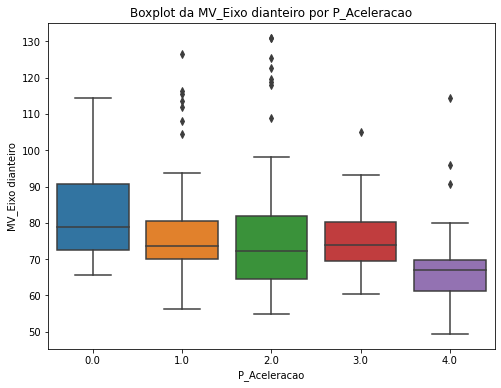

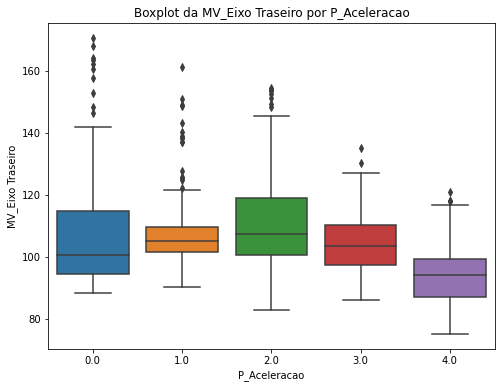

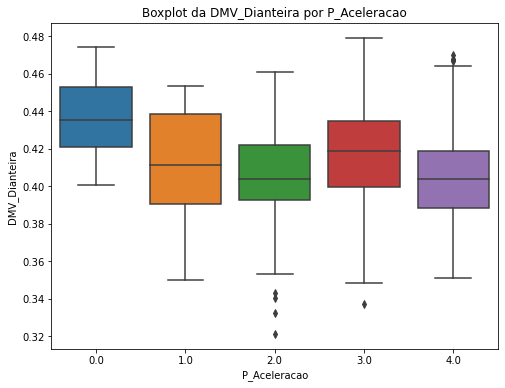

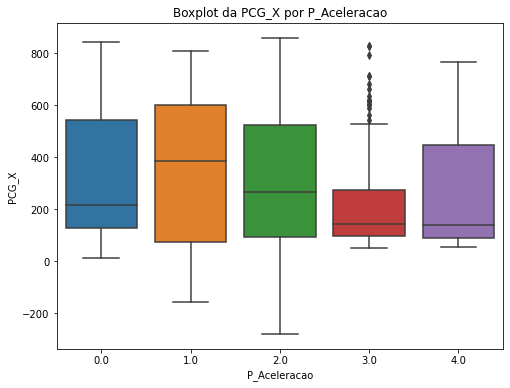

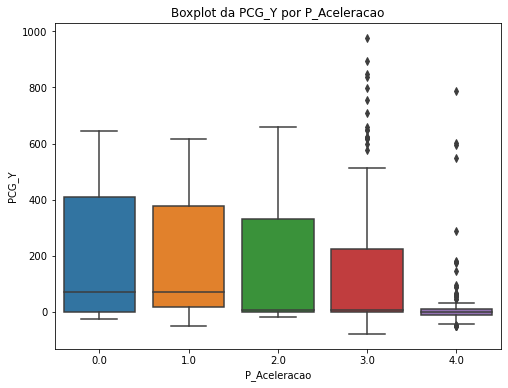

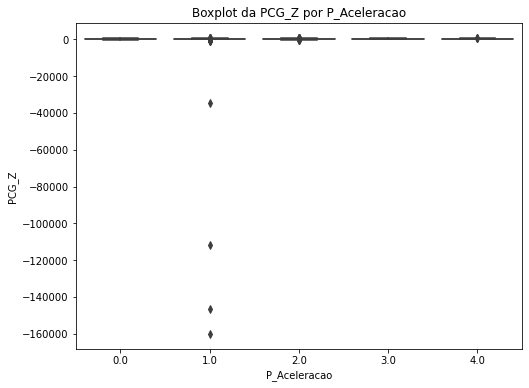

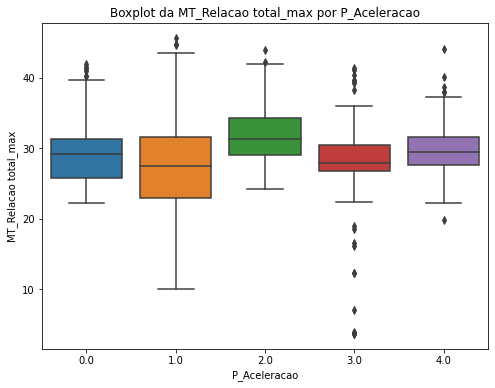

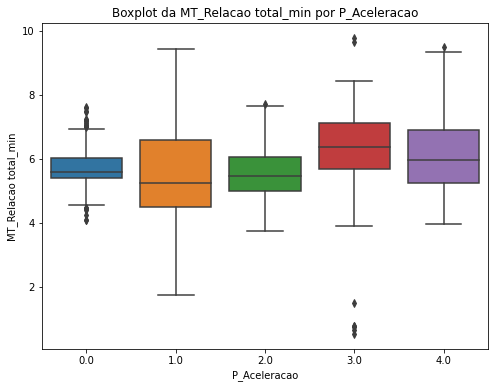

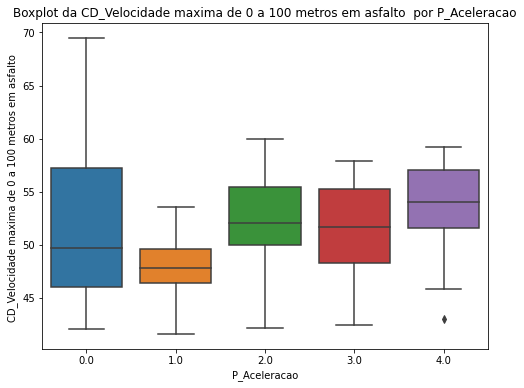

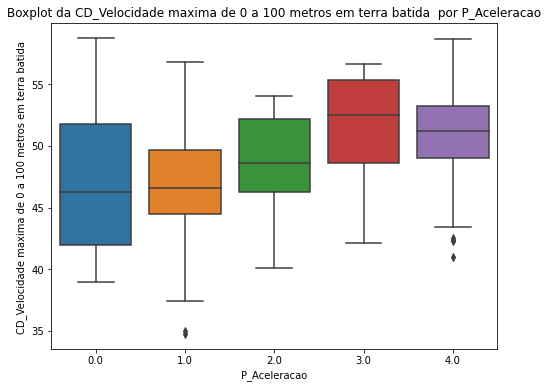

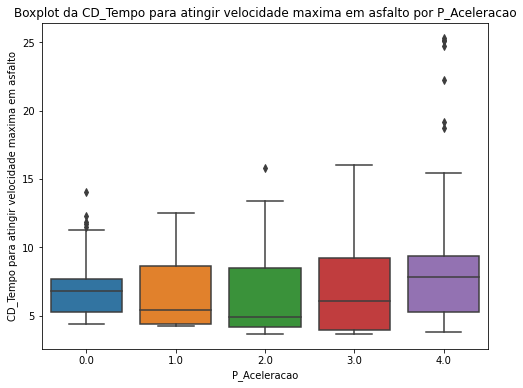

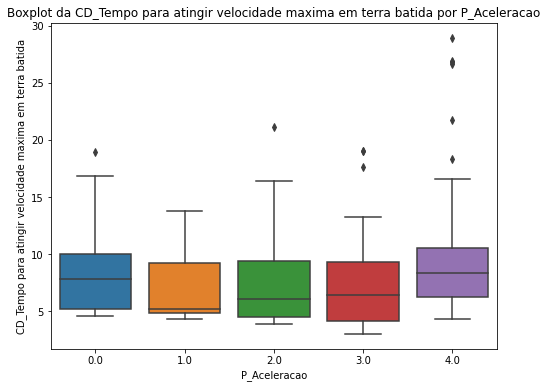

In [27]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Aceleracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Aceleracao', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Aceleracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Aceleracao')
        plt.show()

In [28]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Aceleracao']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Aceleracao'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Aceleracao'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()    
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Aceleracao'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

print(df_tratado)

      MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0             77.103974         95.577887       0.454945  208.702782   
1             71.061984         91.039134       0.409187  514.604278   
2             72.050229         93.021177       0.415841  491.093155   
3            102.342058        152.610215       0.434121   85.197422   
4             84.700554        102.049056       0.457152  368.632469   
...                 ...               ...            ...         ...   
995           72.221809         90.226812       0.441886  107.916108   
996           70.709528         98.908065       0.401583   69.576836   
997           60.558489        107.230112       0.352453  523.000000   
998           69.774043         96.836258       0.410884  109.438324   
1000         114.320000         86.580000       0.432000  629.400000   

           PCG_Y       PCG_Z  MT_Relacao total_max  MT_Relacao total_min  \
0     -22.463140  198.449195             27.844530         

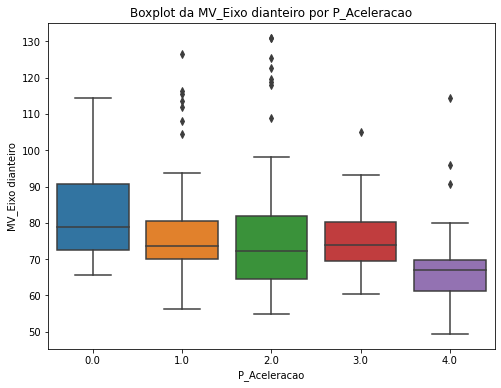

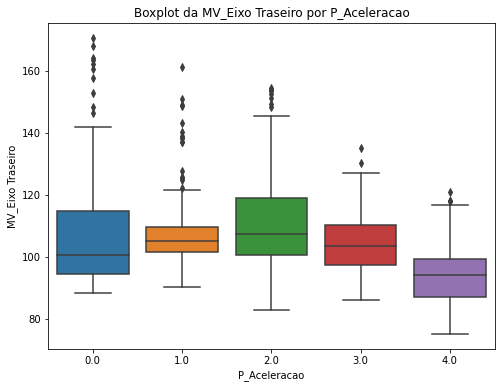

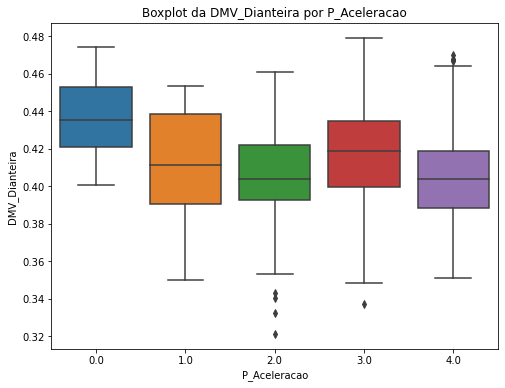

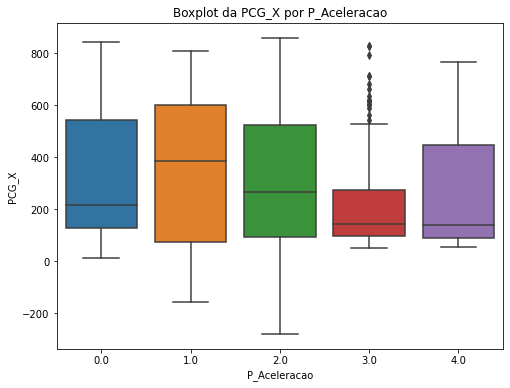

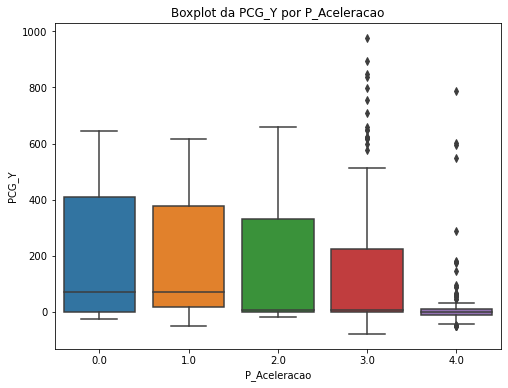

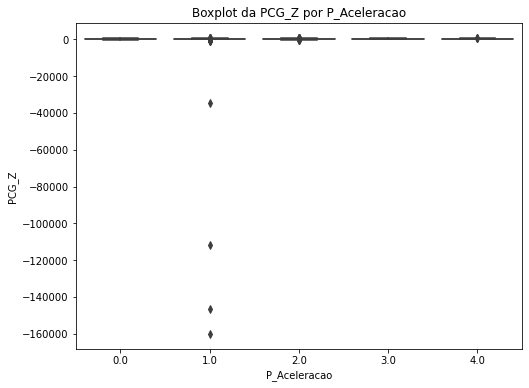

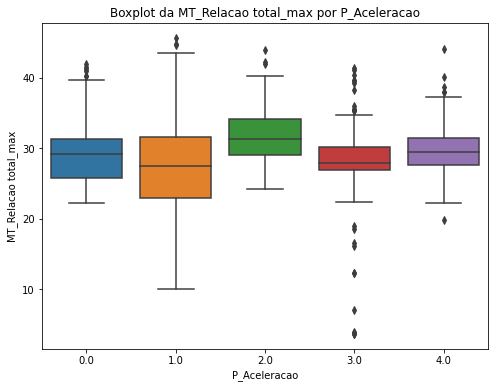

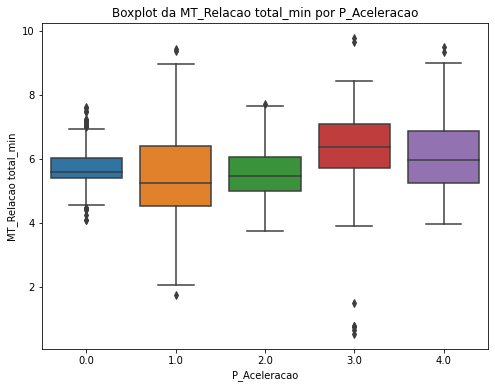

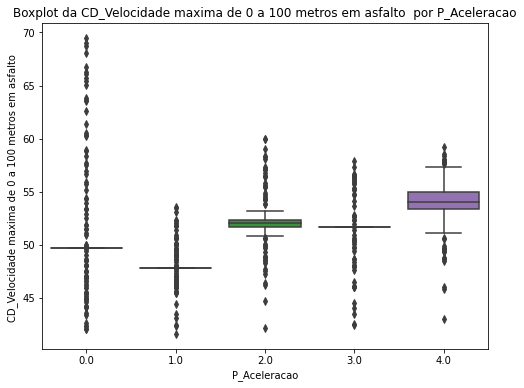

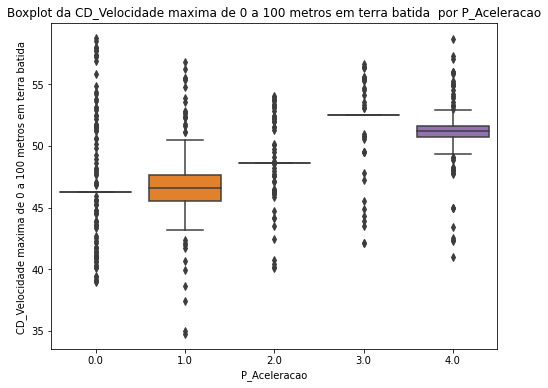

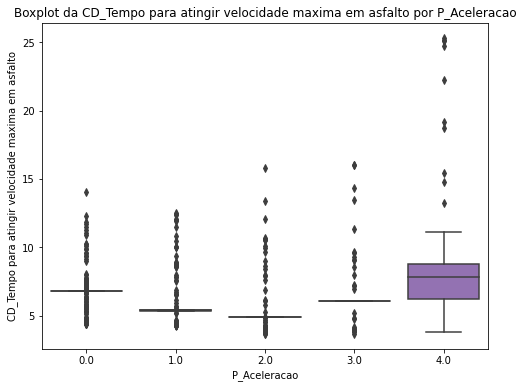

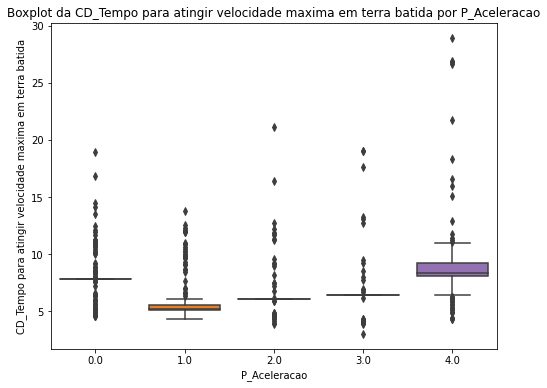

In [29]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Aceleracao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Aceleracao', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Aceleracao')
        plt.ylabel(coluna)
        plt.xlabel('P_Aceleracao')
        plt.show()

In [30]:
df = df_tratado

In [31]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=0)

In [32]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

## Análise de Variáveis

In [ ]:
data_corr = df.drop(['P_Aceleracao'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

In [ ]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [78]:
# Aplicar PCA para reduzir variáveis de alta correlação - Massa
variaveis_reduzidas = dados_treino[['MV_Eixo dianteiro', 'MV_Eixo Traseiro']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'MV_Eixo dianteiro',
    'MV_Eixo Traseiro',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 0

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'Massa', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0     -3.213880       0.454945  208.702782  -22.463140  198.449195   
1    -10.567705       0.409187  514.604278   69.508500  630.194867   
2     -8.412126       0.415841  491.093155  378.006613  265.328190   
3     16.709562       0.434121   85.197422   -2.070284  288.244467   
4      6.619715       0.457152  368.632469   69.508500   39.025558   
...         ...            ...         ...         ...         ...   
995  -10.450001       0.441886  107.916108    6.642557  170.670043   
996   -4.745423       0.401583   69.576836    2.948500  213.702451   
997   -4.843765       0.352453  523.000000  -50.000000  189.770000   
998   -6.936237       0.410884  109.438324    9.533358  112.004513   
1000 -16.665088       0.432000  139.552625    0.016100  189.600000   

      MT_Relacao total_max  MT_Relacao total_min  \
0                27.844530              5.094629   
1                36.113022              5.714850   
2  

In [79]:
# Aplicar PCA para reduzir variáveis de alta correlação - Velocidade em 100 m
variaveis_reduzidas = df[['CD_Velocidade maxima de 0 a 100 metros em asfalto ', 'CD_Velocidade maxima de 0 a 100 metros em terra batida ']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida '
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 7

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Velocidade em 100 m', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0     -3.213880       0.454945  208.702782  -22.463140  198.449195   
1    -10.567705       0.409187  514.604278   69.508500  630.194867   
2     -8.412126       0.415841  491.093155  378.006613  265.328190   
3     16.709562       0.434121   85.197422   -2.070284  288.244467   
4      6.619715       0.457152  368.632469   69.508500   39.025558   
...         ...            ...         ...         ...         ...   
995  -10.450001       0.441886  107.916108    6.642557  170.670043   
996   -4.745423       0.401583   69.576836    2.948500  213.702451   
997   -4.843765       0.352453  523.000000  -50.000000  189.770000   
998   -6.936237       0.410884  109.438324    9.533358  112.004513   
1000 -16.665088       0.432000  139.552625    0.016100  189.600000   

      MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
0                27.844530              5.094629               -2.629481   
1      

In [80]:
# Aplicar PCA para reduzir variáveis de alta correlação - Tempo para atingir velocidade maxima
variaveis_reduzidas = df[['CD_Tempo para atingir velocidade maxima em asfalto', 'CD_Tempo para atingir velocidade maxima em terra batida']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida'
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 8

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'CD_Tempo para atingir velocidade maxima', variavel_reduzida)

print(df)

          Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0     -3.213880       0.454945  208.702782  -22.463140  198.449195   
1    -10.567705       0.409187  514.604278   69.508500  630.194867   
2     -8.412126       0.415841  491.093155  378.006613  265.328190   
3     16.709562       0.434121   85.197422   -2.070284  288.244467   
4      6.619715       0.457152  368.632469   69.508500   39.025558   
...         ...            ...         ...         ...         ...   
995  -10.450001       0.441886  107.916108    6.642557  170.670043   
996   -4.745423       0.401583   69.576836    2.948500  213.702451   
997   -4.843765       0.352453  523.000000  -50.000000  189.770000   
998   -6.936237       0.410884  109.438324    9.533358  112.004513   
1000 -16.665088       0.432000  139.552625    0.016100  189.600000   

      MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
0                27.844530              5.094629               -2.629481   
1      

In [81]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Aceleracao')

# Converta a série em um DataFrame com uma única linha
dados_MB24 = dados_MB24.to_frame().T

print(dados_MB24)

          Massa  DMV_Dianteira       PCG_X   PCG_Y  PCG_Z  \
1000 -16.665088          0.432  139.552625  0.0161  189.6   

      MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
1000                 29.48              5.956629                  3.9521   

      CD_Tempo para atingir velocidade maxima  
1000                                -3.239683  


## Balanceamento de Classes

In [35]:
# Separar X e Y
X = dados_treino.iloc[:, :-1]
Y = dados_treino.iloc[:, -1]

In [36]:
# Verificar o balanceamento original
print('Contagem de classes antes do SMOTE:', Counter(Y))

Contagem de classes antes do SMOTE: Counter({0.0: 142, 1.0: 118, 2.0: 87, 4.0: 85, 3.0: 83})


In [86]:
# Aplicar SMOTE ao conjunto inteiro
smote = SMOTE(sampling_strategy='auto', random_state=1)
X, Y = smote.fit_resample(X, Y)

In [87]:
# Verificar a contagem de classes após o SMOTE
print('Contagem de classes após o SMOTE:', Counter(Y))

Contagem de classes após o SMOTE: Counter({0.0: 200, 1.0: 200, 2.0: 200, 3.0: 200, 4.0: 200})


In [88]:
# Junte X e Y em um único DataFrame
df = pd.concat([X, Y], axis=1)
print(df)

         Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0    -3.213880       0.454945  208.702782  -22.463140  198.449195   
1   -10.567705       0.409187  514.604278   69.508500  630.194867   
2    -8.412126       0.415841  491.093155  378.006613  265.328190   
3    16.709562       0.434121   85.197422   -2.070284  288.244467   
4     6.619715       0.457152  368.632469   69.508500   39.025558   
..         ...            ...         ...         ...         ...   
995 -18.225184       0.415545  322.650589   -9.086212  257.867349   
996 -12.852014       0.404040  141.265291  182.375652  208.185594   
997 -11.542656       0.413324   73.246776    6.382785  150.518883   
998  -9.257428       0.394534  523.000000  -50.000000  189.770000   
999 -12.962643       0.439140   89.400957    2.760295  153.317246   

     MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
0               27.844530              5.094629               -2.629481   
1               36.11

In [89]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(Y_teste)

85     0.0
966    4.0
505    3.0
490    3.0
272    1.0
      ... 
688    4.0
329    1.0
263    1.0
773    1.0
554    3.0
Name: P_Aceleracao, Length: 300, dtype: float64


In [4]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_acel.xlsx'

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

dados_treino = xl.parse()

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

print(dados_treino)

         Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0    -3.213880       0.454945  208.702782  -22.463140  198.449195   
1   -10.567705       0.409187  514.604278   69.508500  630.194867   
2    -8.412126       0.415841  491.093155  378.006613  265.328190   
3    16.709562       0.434121   85.197422   -2.070284  288.244467   
4     6.619715       0.457152  368.632469   69.508500   39.025558   
..         ...            ...         ...         ...         ...   
995 -18.225184       0.415545  322.650589   -9.086212  257.867349   
996 -12.852014       0.404040  141.265291  182.375652  208.185594   
997 -11.542656       0.413324   73.246776    6.382785  150.518883   
998  -9.257428       0.394534  523.000000  -50.000000  189.770000   
999 -12.962643       0.439140   89.400957    2.760295  153.317246   

     MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
0               27.844530              5.094629               -2.629481   
1               36.11

In [5]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_acel.xlsx'

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

dados_teste = xl.parse()

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_teste)

         Massa  DMV_Dianteira       PCG_X       PCG_Y       PCG_Z  \
0    -3.213880       0.454945  208.702782  -22.463140  198.449195   
1   -10.567705       0.409187  514.604278   69.508500  630.194867   
2    -8.412126       0.415841  491.093155  378.006613  265.328190   
3    16.709562       0.434121   85.197422   -2.070284  288.244467   
4     6.619715       0.457152  368.632469   69.508500   39.025558   
..         ...            ...         ...         ...         ...   
995 -18.225184       0.415545  322.650589   -9.086212  257.867349   
996 -12.852014       0.404040  141.265291  182.375652  208.185594   
997 -11.542656       0.413324   73.246776    6.382785  150.518883   
998  -9.257428       0.394534  523.000000  -50.000000  189.770000   
999 -12.962643       0.439140   89.400957    2.760295  153.317246   

     MT_Relacao total_max  MT_Relacao total_min  CD_Velocidade em 100 m  \
0               27.844530              5.094629               -2.629481   
1               36.11

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [90]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [91]:
# Modelo de Classificação de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [92]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [93]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [94]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(criterion='entropy', max_depth=15, max_features='sqrt')

## Classificação de Floresta Aleatória

In [95]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidParam

In [96]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=30)

## Extreme Gradient Boosting

In [ ]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

#grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

#grid_search.fit(X_treino, Y_treino)

#best_params = grid_search.best_params_
#best_estimator = grid_search.best_estimator_

In [97]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

In [98]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_features='sqrt',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, ...)

# Validação Cruzada

In [99]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Árvore de Decisão de Classificação

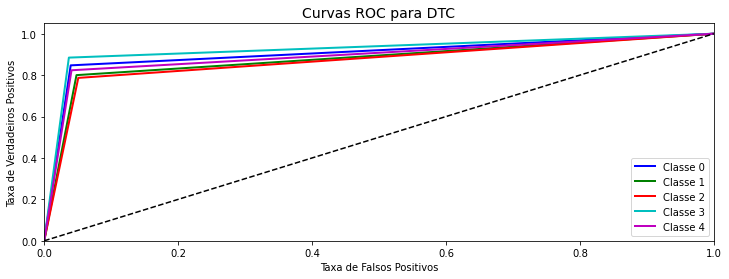

In [100]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [101]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_DTC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 81.71%
Intervalo de acurácia: [78.03% ~ 85.40%]


## Classificação de Floresta Aleatória

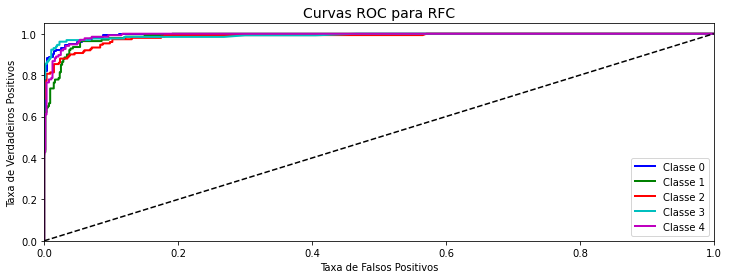

In [102]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [103]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 90.43%
Intervalo de acurácia: [88.29% ~ 92.57%]


## Extreme Gradient Boosting

[11:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[11:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



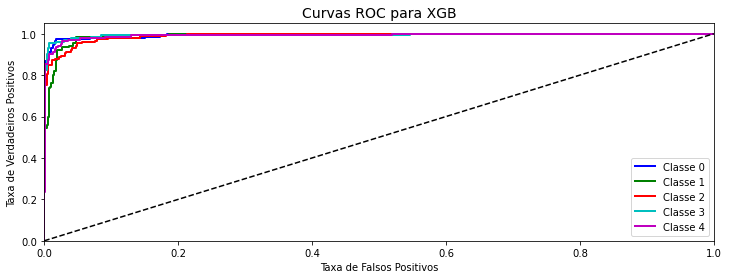

In [104]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [105]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

[11:12:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.

[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



Acurácia média: 92.43%
Intervalo de acurácia: [87.86% ~ 97.00%]


[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



# Desempate

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [106]:
# Treinamento do modelo 
model_XGB.fit(X_treino, Y_treino) # Checar modelo

[11:12:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_features='sqrt',
              max_leaves=None, min_child_weight=None, min_samples_leaf=1,
              min_samples_split=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=30, ...)

# Avaliação

In [107]:
# Fazer previsões no conjunto de teste
Y_pred = model_XGB.predict(X_teste)

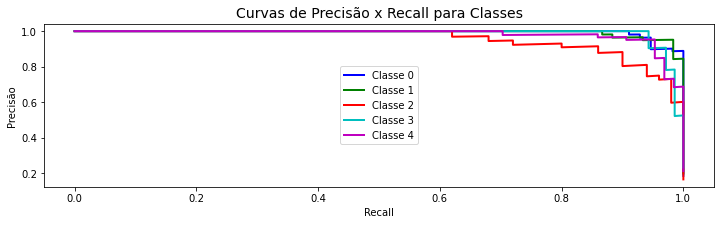

In [108]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_XGB.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [109]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
Y_pred = model_XGB.predict(X_teste)

# Calcule a acurácia
accuracy = accuracy_score(Y_teste, Y_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.94


## Análise de Variáveis 

In [ ]:
# Analisar variáveis que mais afetam o modelo
importances = model_XGB.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

In [ ]:
# Crie um objeto explainer
explainer = shap.Explainer(model_XGB, X_teste)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [30]:
print(dados_treino.columns)

Index(['Massa', 'DMV_Dianteira', 'PCG_X', 'PCG_Y', 'PCG_Z',
       'MT_Relacao total_max', 'MT_Relacao total_min',
       'CD_Velocidade em 100 m', 'CD_Tempo para atingir velocidade maxima',
       'P_Aceleracao'],
      dtype='object')


In [50]:
print(dados_MB24)

Massa                                      -16.665088
DMV_Dianteira                                0.432000
PCG_X                                      139.552625
PCG_Y                                        0.016100
PCG_Z                                      189.600000
MT_Relacao total_max                        29.480000
MT_Relacao total_min                         5.956629
CD_Velocidade em 100 m                       3.952100
CD_Tempo para atingir velocidade maxima     -3.239683
Name: 1000, dtype: float64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\MB24.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
dados_MB24.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=0)

In [110]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = model_XGB.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')

A previsão para X_prev é: 4.00
